# Sobel Operator
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [sobel_operator.ipynb](https://github.com/diegoinacio/computer-vision-notebooks/blob/master/Computer-Vision-Fundamentals/sobel_operator.ipynb)
---
Sobel and gradient operation with spatial filtering.

In [1]:
%matplotlib inline
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Linear algebra operations
import numpy as np

# Image IO
import imageio

# Performance
from numba import jit, prange

# Utils
from _utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Sobel operator
---
The [Sobel–Feldman](https://en.wikipedia.org/wiki/Sobel_operator#Extension_to_other_dimensions) is a gradient operator that consists of two separable convolutional operations:

- Smoothing perpendicular to the derivative direction with a triangle filter
- Simple central difference in the derivative direction

Given that, we could define the operations as:

$$ \large
G_x = 
\begin{bmatrix}
1 \\
2 \\
1
\end{bmatrix}
* \left(
\begin{bmatrix}
+1 & 0 & -1
\end{bmatrix}
*I \right)
=
\begin{bmatrix}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{bmatrix}
* I
$$


$$ \large
G_y = 
\begin{bmatrix}
+1 \\
0 \\
-1
\end{bmatrix}
* \left(
\begin{bmatrix}
1 & 2 & 1
\end{bmatrix}
*I \right)
=
\begin{bmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
* I
$$

In [3]:
# Triangle filter
ht = np.array([[1, 2, 1]])

# Central difference
hc = np.array([[1, 0, -1]])

# Sobel operator
Hx = ht.T*hc
Hy = hc.T*ht

print(Hx, end=' Hx\n\n')
print(Hy, end=' Hy\n\n')

[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]] Hx

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] Hy



In [4]:
@jit(nopython=True, parallel=True)
def convolve(x, h):
    xh, xw = x.shape
    hh, hw = h.shape
    # Kernel radius
    rh, rw = np.array(h.shape)//2
    # Init output
    output = np.zeros(x.shape)
    for n1 in prange(rh, xh-rh):
        for n2 in prange(rw, xw-rw):
            value = 0
            for k1 in prange(hh):
                for k2 in prange(hw):
                    value += h[k1, k2]*x[n1 + k1 - rh, n2 + k2 - rw]
            output[n1, n2] = value
    return output

## Sobel operator and patial filtering
---
Applying *Sobel operator* as spatial filtering by the application of *discrete convolution* on images.

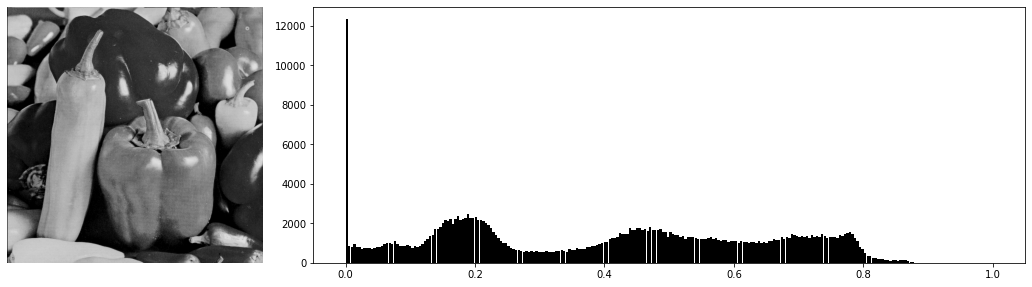

In [5]:
img_in = imageio.imread('../_data/pimentos.png')/255
img_in = np.median(img_in, axis=2)
histogram(img_in, interval=[0, 1])

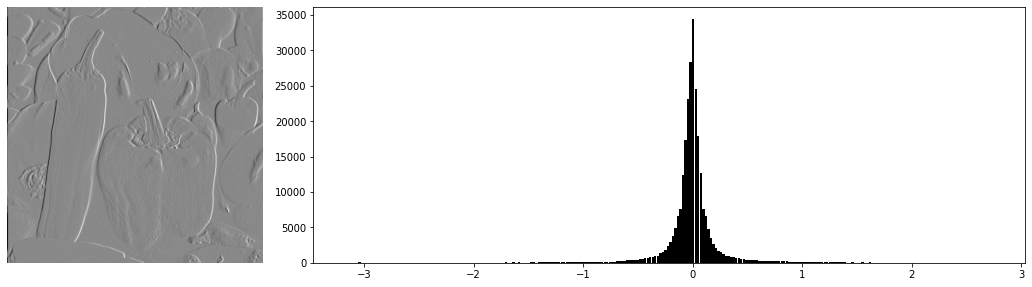

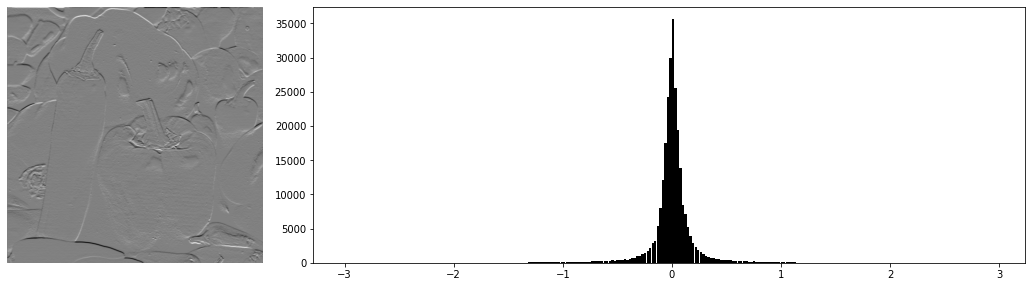

Wall time: 2.45 s


In [6]:
%%time
r = 1

# Padding zero
img_pad = np.pad(
    img_in,
    ((r, r), (r, r)),
    'edge'
)

# Convolution
Gx = convolve(img_pad, Hx)[r:-r, r:-r]
histogram(Gx,interval=[Gx.min(), Gx.max()])

Gy = convolve(img_pad, Hy)[r:-r, r:-r]
histogram(Gy, interval=[Gy.min(), Gy.max()])

The *gradient magnitude* is defined as:

$$ \large
G = \sqrt{G_x^2+G_y^2}
$$

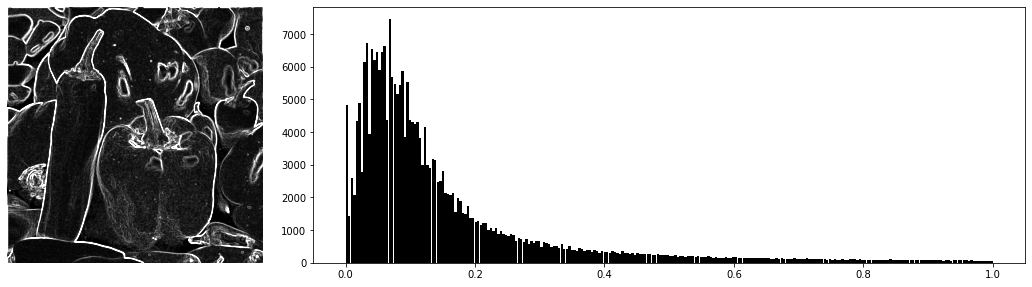

In [7]:
G = (Gx**2 + Gy**2)**0.5
histogram(G, interval=[0, 1])

The *gradient direction* is defined as:

$$ \large
\Theta = \arctan\left(\frac{G_y}{G_x}\right)
$$

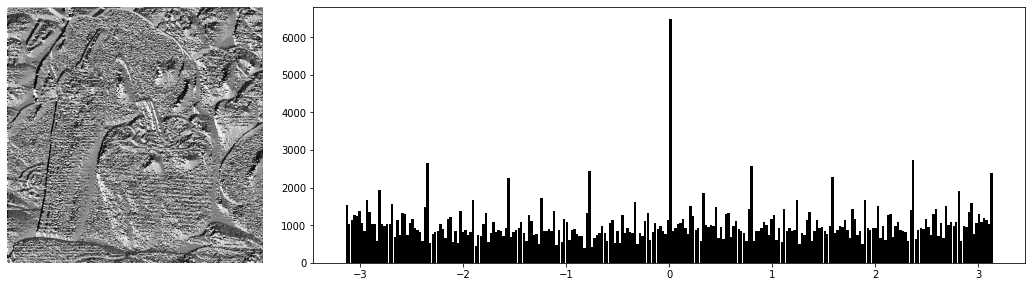

In [8]:
Theta = np.arctan2(Gy, Gx)
histogram(Theta, interval=[Theta.min(), Theta.max()])

## Different operator sizes
---

In [9]:
def SobelOp(radius, direction="x"):
    size = 2*radius + 1
    
    # Triangle filter
    ht = np.arange(size) + 1
    ht[size//2:] = ht[::-1][size//2:]
    ht = ht[np.newaxis]
    
    # Central difference
    hc = np.arange(size)
    hc = hc[::-1] - size//2
    hc = hc[np.newaxis]
    
    # Sobel operator
    if(direction == "y"):
        return hc.T*ht
    return ht.T*hc

print(SobelOp(2, "x"), end=' Hx 5x5\n\n')
print(SobelOp(2, "y"), end=' Hy 5x5\n\n')

[[ 2  1  0 -1 -2]
 [ 4  2  0 -2 -4]
 [ 6  3  0 -3 -6]
 [ 4  2  0 -2 -4]
 [ 2  1  0 -1 -2]] Hx 5x5

[[ 2  4  6  4  2]
 [ 1  2  3  2  1]
 [ 0  0  0  0  0]
 [-1 -2 -3 -2 -1]
 [-2 -4 -6 -4 -2]] Hy 5x5



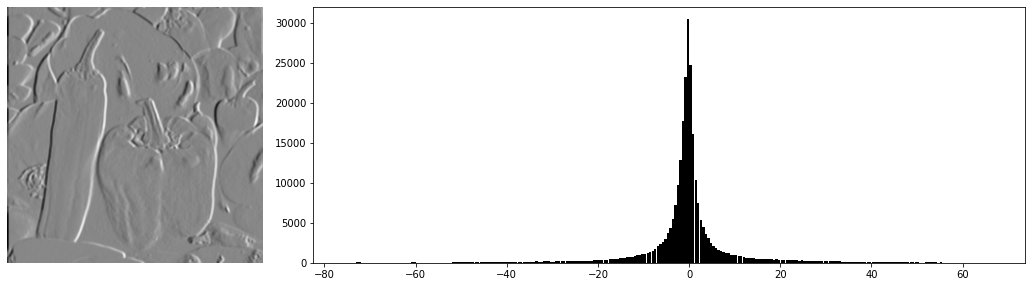

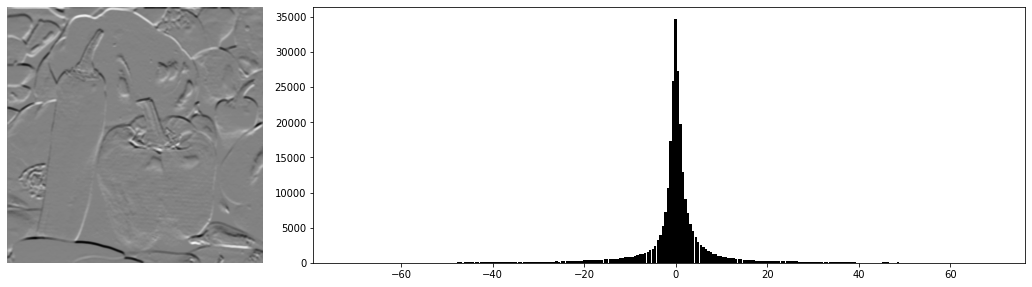

Wall time: 888 ms


In [10]:
%%time
r = 3

# Padding zero
img_pad = np.pad(
    img_in,
    ((r, r), (r, r)),
    'edge'
)

# Convolution
Gx = convolve(img_pad, SobelOp(r, "x"))[r:-r, r:-r]
histogram(Gx,interval=[Gx.min(), Gx.max()])

Gy = convolve(img_pad, SobelOp(r, "y"))[r:-r, r:-r]
histogram(Gy, interval=[Gy.min(), Gy.max()])